# Timbre Encoder
This is the notebook used to train the Vocal Pitch Modulator.

This notebook makes use of the data to train our timbre encoder, which is a VAE that takes in an MFCC, reduces its dimensionality, and attempts to reconstruct the provided MFCC.

The first cells are the "walkthrough" that we used to verify the data at each stage, while the latter section ("Experiment" sections) are the cells run per experiment.

## Global variables/Imports
Run these cells before running either of the following sections.

In [9]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport ANN
from ANN import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

### Constants
Used to tune the data generation and ANN.

In [11]:
n_mfccs = [ 40, 24, 12 ]
n_mels = 256
n_ffts = 2048

### Data Generation
This is all the code that was explained in the Data Walkthrough. It generates data structures to hold all wav file data, spectrograms, mel spectra and MFCC data for all wav files.

For diagram-visualization of the data set, refer to the [readme](https://github.com/zioul123/VocalPitchModulator/blob/master/README.md).

For the classifier, MFCC are normalized by row to `[-1, 1]`, as the classifer can learn it better.
For the VAE, MFCC are normalized by row to `[0, 1]`, to allow the VAE to output it.

In [12]:
# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
# mels:         (576, 128, 58) (n_wavs, n_mels, n_windows)
# mfccs:        (576, 20, 58)  (n_wavs, n_mfcc, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, win_length=n_ffts, plot=False) 
                              for waveform in all_wav_data ])

### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.

Generate `data` and `labels` from `all_mfcc` and using `nd_ref_idx`.

Note that `labels` is only used used by the classifier, and not TimbreVAE.

In [13]:
n_mfcc = n_mfccs[0]
all_mels, all_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                           for ffts in all_spectrograms ])))
n_files, n_mfcc_dummy, n_windows = all_mfcc.shape

# Returns a flat 2d idx, given a wavfile index and a window index
flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
    wav_idx, win_idx, n_files, n_windows)

# data:   (33408, 20) (n_wavs * n_windows, n_mfcc)
data_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx] 
                          for wav_file_idx in range(n_files) 
                          for window_idx in range(n_windows) ])

# Globally normalize to [-1, 1]
# log(-n) is nan, so we put things on a log scale from absolute values, and
# mutliply the sign back.
signs = np.sign(data_prenorm)
data_logged = np.log(np.abs(data_prenorm))
max_mfcc = np.max(np.abs(data_logged))
data = data_logged / max_mfcc
# If going to zero-one
# data = normalize_rows(data, NormMode.NEG_ONE_ONE_TO_ZERO_ONE)

[-1.4232253e+02  2.5124673e+02 -3.5486549e+01  7.2455963e+01
  3.2391647e+01  5.8577888e+01 -9.0863409e+00 -2.3206078e+01
 -3.1755833e+01 -1.1568871e+01  1.5435003e+01 -1.6487875e+01
 -6.3505516e+00  1.6824434e+01 -3.1595240e+00  7.1181893e-01
  2.4520906e+01  1.6444090e+01 -4.0628190e+00 -1.6550110e+01
  5.4667397e+00 -1.1811255e+01 -2.3326445e-01 -1.9993465e+01
 -1.1135010e+01 -8.1160154e+00 -4.9543185e+00  7.8407574e+00
 -1.8072077e+01  2.9504021e+01  7.4153967e+00 -4.5475411e+00
  1.9492166e+00 -1.2899987e+01 -1.4165734e+01 -8.2396507e+00
 -9.3923483e+00 -7.5823956e+00  1.2699495e+01 -1.1117794e+01]
[ 0.50722885  0.5653718   0.36513573  0.4381623   0.3558002   0.41641042
  0.22575979  0.32168353  0.35377216  0.25047067  0.2799667   0.2867174
  0.18911165  0.28878468  0.11769175 -0.03477609  0.32732162  0.28644538
  0.14341645  0.28710285  0.17378059  0.25259194 -0.14891069  0.30643946
  0.24656026  0.2142064   0.16371162  0.21067654  0.296103    0.34624776
  0.20497036  0.15494701 

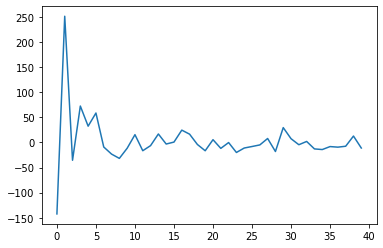

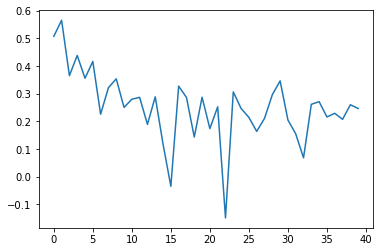

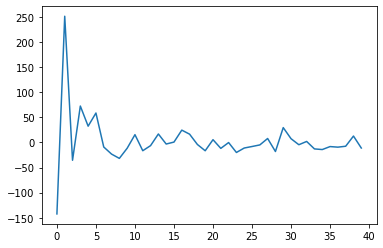

In [14]:
# To restore:
restored_data = signs * np.e ** (data * max_mfcc)
# If going to zero-one
# restored_data = signs * np.e ** np.abs(
#     denormalize_rows(data, DenormMode.ZERO_ONE_TO_NEG_ONE_ONE) * max_mfcc)
# Visualize MFCCs
plt.figure()
plt.plot(data_prenorm[0])
plt.figure()
plt.plot(data[0])
plt.figure()
plt.plot(restored_data[0])
# Numeric verification
print(data_prenorm[0])
print(data[0])
print(restored_data[0])

Split Data into `train` and `test`, and convert to Torch tensors of the correct types. Run **only one of these cells.**

First method (**not-recommended**, simple): Random sampling to train and test

In [ ]:
# X_train, Y_train: (25056, 20) (25056) 
# X_val, Y_val:     (8352, 20) (8352)
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
# Used as index, so it is long
Y_train = Y_train.long(); Y_val = Y_val.long()

Second method **(recommended)**: 1 person from each wav will be the test data

In [15]:
# X_train: (22272, 20)
# X_val: (11136, 20)
X_train = []; X_val = [];
for vow_idx in range(n_vowels):
    for pit_idx in range(n_pitches):
        # Choose the person for this pitch/vowel to be used as test data
        test_pid = int(np.random.rand() * 3)
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
            if (pid_idx != test_pid):
                for win_idx in range(n_windows):
                    X_train.append(data[flat_data_idx(wav_idx, win_idx)])
            else:
                for win_idx in range(n_windows):
                    X_val.append(data[flat_data_idx(wav_idx, win_idx)])
X_train, X_val = map(torch.tensor, (X_train, X_val))
# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()

### Timbre-VAE - MFCC -> MFCC
This takes MFCC, reduces dimensionality to a `n_timb` latent space, and attempts to recreate the MFCC.

In [ ]:
n_hid = 10; n_timb = 4; lr = 1e-3; n_epochs = 2000; batch_size=22272

# Training model 
model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

# Define loss - from pytorch VAE example.
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

In [ ]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
X_val = X_val.to(device)

# Move the network to GPU (if possible)
model.to(device) 
# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
train_loss, val_loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                        epochs=n_epochs, print_graph = True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(train_loss, toc - tic))

Saving the model

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
                          "TimbreVAE_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{:.6f}.pt"
                          .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Loading the saved model, and using the model for prediction example

In [ ]:
model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)
model.load_state_dict(torch.load(model_path))
model.eval()

data_tensor = torch.tensor(data)
data_tensor = data_tensor.float();

wav_idx = flat_ref_idx(5, 5, 1)
data_idx = flat_data_idx(wav_idx, 30)
label = data_tensor[data_idx]
pred, _, _ = model(data_tensor)

# To restore:
restored_pred = signs * np.e ** np.abs(
    denormalize_rows(pred.detach().numpy(), DenormMode.ZERO_ONE_TO_NEG_ONE_ONE) * max_mfcc)
    
# Visualize MFCCs
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle("TimbreVAE lr{} n_epochs{} n_mfcc{} n_hid{} n_timb{} loss{:.6f}"
             .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
# plt.figure()
ax[0].plot(data_prenorm[data_idx])
ax[0].plot(restored_pred[data_idx])
# fig, ax = plt.subplots(2, 1)
# plt.figure()
ax[1].plot(data[data_idx])
ax[1].plot(pred.detach().numpy()[data_idx])
fig.savefig(os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
    "TimbreVAE_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{:.6f}.jpg"
            .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss)))

# Numeric verification
np.set_printoptions(suppress=True)
print(data_prenorm[data_idx])
print(restored_pred[data_idx])
print(data[data_idx])
print(pred.detach().numpy()[data_idx])

# Experiment: Choosing `n_hid`, `n_timb`, `n_mfcc`

Linear, relu, linear/linear/reparam, linear, relu, linear, sigmoid (normalized data from 0-1), BCE+KLD

From running this, we find the results:  
For n_mfcc=12: 12, 10, 8  
For n_mfcc=24: 24, 10, 4  
For n_mfcc=40: 40, 38, 8

In [18]:
n_mels = 256
n_ffts = 2048

%matplotlib agg
%matplotlib agg

# # # # # # # # # # # # # # # # # # # # # # # # # #
# Data that is constant throughout the entire run #
# # # # # # # # # # # # # # # # # # # # # # # # # #

# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)
# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, win_length=n_ffts, plot=False) 
                              for waveform in all_wav_data ])

# Define loss - from pytorch VAE example.
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# # # # # # # # # # # # # # # # # # # 
# Data that is constant per n_mfcc  #
# # # # # # # # # # # # # # # # # # # 

def create_data_for_mfcc(n_mfcc):
    # mels:         (576, 128, 58) (n_wavs, n_mels, n_windows)
    # mfccs:        (576, 20, 58)  (n_wavs, n_mfcc, n_windows)
    all_mels, all_mfcc = map(np.array, map(list, zip(*
                             [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                               for ffts in all_spectrograms ])))
    n_files, n_mfcc_dummy, n_windows = all_mfcc.shape

    # Returns a flat 2d idx, given a wavfile index and a window index
    flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
        wav_idx, win_idx, n_files, n_windows)

    # data:   (33408, 20) (n_wavs * n_windows, n_mfcc)
    data_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx] 
                              for wav_file_idx in range(n_files) 
                              for window_idx in range(n_windows) ])

    # Globally normalize to [0, 1]
    # log(-n) is nan, so we put things on a log scale from absolute values, and
    # mutliply the sign back.
    signs = np.sign(data_prenorm)
    data_logged = np.log(np.abs(data_prenorm))
    max_mfcc = np.max(np.abs(data_logged))
    data_negtopos = data_logged / max_mfcc
    data = normalize_rows(data_negtopos, NormMode.NEG_ONE_ONE_TO_ZERO_ONE)  
    
    # X_train: (22272, 20)
    # X_val: (11136, 20)
    X_train = []; X_val = [];
    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):
            # Choose the person for this pitch/vowel to be used as test data
            test_pid = int(np.random.rand() * 3)
            for pid_idx in range(n_people):
                wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                if (pid_idx != test_pid):
                    for win_idx in range(n_windows):
                        X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                else:
                    for win_idx in range(n_windows):
                        X_val.append(data[flat_data_idx(wav_idx, win_idx)])
    X_train, X_val = map(torch.tensor, (X_train, X_val))
    # Default tensor is float
    X_train = X_train.float(); X_val = X_val.float()
    
    return data, data_prenorm, max_mfcc, signs, flat_data_idx, X_train, X_val

# # # # # # # # # # # # # #
# Actual experiment loop  #
# # # # # # # # # # # # # # 

# Results: 
# Indices: [ [ n_mfcc, n_hid, n_timb ], [ ... ], ... ]
# Losses: [ loss1, loss2, ... ]
indices = []; train_losses = []; val_losses = [];

n_mfccs = [ 40, 24, 12 ]
n_hid_candidates = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]
n_timb_candidates = [4, 6, 8, 10 ] # >= 12 means we might as well have used 12 mfcc
f = open(os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", "Log.txt"), "w")
for n_mfcc in n_mfccs:
    data, data_prenorm, max_mfcc, signs, flat_data_idx, X_train, X_val = create_data_for_mfcc(n_mfcc)
    lr = 1e-3; n_epochs = 2000; batch_size=22272

    for n_hid in n_hid_candidates:
        for n_timb in n_timb_candidates:
            if (n_timb >= n_hid) or (n_timb >= n_mfcc) or (n_hid >= n_mfcc):
                continue

            # Training model 
            model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

            # Use GPU if possible (will run on CPU otherwise)
            device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

            # Move inputs to GPU (if possible)
            X_train = X_train.to(device)
            X_val = X_val.to(device)

            # Move the network to GPU (if possible)
            model.to(device) 
            # Define optimizer 
            # opt = optim.SGD(model.parameters(), lr=lr)
            opt = optim.Adam(model.parameters(), lr=lr)

            # Fit the model
            tic = time.time()
            train_loss, val_loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                                    epochs=n_epochs, print_graph = True, desc="n_mfcc{},n_hid{},n_timb{}".format(n_mfcc, n_hid, n_timb))
            toc = time.time()
            print('Final loss: {}\t\tTime taken: {}'.format(train_loss, toc - tic))
            model_path = os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
                                      "TimbreVAE_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{:.6f}.pt"
                                      .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
            torch.save(model.state_dict(), model_path)
            print("Model saved at {}".format(model_path))

            indices.append([n_mfcc, n_hid, n_timb]); train_losses.append(train_loss); val_losses.append(val_loss)

            # Create the validation printout and graph
            data_tensor = torch.tensor(data)
            data_tensor = data_tensor.float();
            data_tensor = data_tensor.to(device)

            wav_idx = flat_ref_idx(5, 5, 1)
            data_idx = flat_data_idx(wav_idx, 30)
            label = data_tensor[data_idx]
            pred, _, _ = model(data_tensor)

            # To restore:
            restored_pred = signs * np.e ** (
                denormalize_rows(pred.cpu().detach().numpy(), DenormMode.ZERO_ONE_TO_NEG_ONE_ONE) * max_mfcc)
            # Visualize MFCCs
            fig, ax = plt.subplots(2, 1, figsize=(10, 10))
            fig.suptitle("TimbreVAE lr{} n_epochs{} n_mfcc{} n_hid{} n_timb{} loss{:.6f}"
                         .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
            # plt.figure()
            ax[0].plot(data_prenorm[data_idx])
            ax[0].plot(restored_pred[data_idx])
            # fig, ax = plt.subplots(2, 1)
            # plt.figure()
            ax[1].plot(data[data_idx])
            ax[1].plot(pred.cpu().detach().numpy()[data_idx])
            fig.savefig(os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
                "TimbreVAE_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{:.6f}.jpg"
                        .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss)))

            # Numeric verification
            np.set_printoptions(suppress=True)
            f.write("TimbreVAE lr{} n_epochs{} n_mfcc{} n_hid{} n_timb{} loss{:.6f}"
                    .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))

            f.write(str(data_prenorm[data_idx]))
            f.write(str(restored_pred[data_idx]))
            f.write(str(data[data_idx]))
            f.write(str(pred.cpu().detach().numpy()[data_idx]))
f.close()

%matplotlib inline


Training Loss before/after: 28.45667766702586, 26.955838609015803
Validation Loss before/after: 28.434831290409484, 26.95325689206178
Final loss: 26.955838609015803		Time taken: 19.300349950790405
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid10_n_timb4_26.953195.pt



Training Loss before/after: 28.468539533943964, 26.95561972431753
Validation Loss before/after: 28.431932471264368, 26.95299872036638
Final loss: 26.95561972431753		Time taken: 20.529834032058716
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid10_n_timb6_26.953049.pt



Training Loss before/after: 28.329626324533045, 26.95562814295977
Validation Loss before/after: 28.293746071300287, 26.952979076867816
Final loss: 26.95562814295977		Time taken: 20.430832386016846
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid10_n_timb8_26.952987.pt



Training Loss before/after: 28.317472611350574, 26.95610800556753
Validation Loss before/after: 28.293959343570403, 26.953349497126435
Final loss: 26.95610800556753		Time taken: 21.283608198165894
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid12_n_timb4_26.953338.pt



Training Loss before/after: 28.602797234195403, 26.955673042385058
Validation Loss before/after: 28.559957570043103, 26.953038007363507
Final loss: 26.955673042385058		Time taken: 19.93850016593933
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid12_n_timb6_26.953139.pt



Training Loss before/after: 28.390540813577587, 26.955557987607758
Validation Loss before/after: 28.362877155172413, 26.952951014727013
Final loss: 26.955557987607758		Time taken: 18.76777744293213
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid12_n_timb8_26.952959.pt



Training Loss before/after: 28.405020878232758, 26.95568426724138
Validation Loss before/after: 28.385273549748565, 26.953043619791668
Final loss: 26.95568426724138		Time taken: 18.847283840179443
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid12_n_timb10_26.953024.pt



Training Loss before/after: 28.071216100933906, 26.955594468390803
Validation Loss before/after: 28.04327743354885, 26.95299872036638
Final loss: 26.955594468390803		Time taken: 19.411520957946777
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid14_n_timb4_26.953004.pt



Training Loss before/after: 28.200279498922413, 26.95561972431753
Validation Loss before/after: 28.159656743893677, 26.95295662715517
Final loss: 26.95561972431753		Time taken: 21.306511402130127
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid14_n_timb6_26.953004.pt



Training Loss before/after: 28.318516522988507, 26.95564498024425
Validation Loss before/after: 28.299299568965516, 26.95304642600575
Final loss: 26.95564498024425		Time taken: 19.248207092285156
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid14_n_timb8_26.953038.pt



Training Loss before/after: 28.447069190014368, 26.955726360452587
Validation Loss before/after: 28.40168709590517, 26.953096937859197
Final loss: 26.955726360452587		Time taken: 18.14755630493164
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid14_n_timb10_26.953072.pt



Training Loss before/after: 28.21374932650862, 26.955535537895116
Validation Loss before/after: 28.193073141163794, 26.952973464439655
Final loss: 26.955535537895116		Time taken: 17.98383331298828
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid16_n_timb4_26.952948.pt



Training Loss before/after: 28.187637504489942, 26.955614111889368
Validation Loss before/after: 28.14032754130747, 26.952928565014368
Final loss: 26.955614111889368		Time taken: 18.562549352645874
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid16_n_timb6_26.952996.pt



Training Loss before/after: 28.53577642331178, 26.955779678520116
Validation Loss before/after: 28.485012010596265, 26.953155868354884
Final loss: 26.955779678520116		Time taken: 18.05796504020691
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid16_n_timb8_26.953117.pt



Training Loss before/after: 28.228178879310345, 26.955577631106323
Validation Loss before/after: 28.167284033764368, 26.95299872036638
Final loss: 26.955577631106323		Time taken: 18.087127923965454
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid16_n_timb10_26.952987.pt



Training Loss before/after: 28.80414309446839, 26.955838609015803
Validation Loss before/after: 28.735814587823278, 26.953082906788794
Final loss: 26.955838609015803		Time taken: 18.120599269866943
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid18_n_timb4_26.953181.pt



Training Loss before/after: 28.35168036099138, 26.95570110452586
Validation Loss before/after: 28.287269329202587, 26.953043619791668
Final loss: 26.95570110452586		Time taken: 18.175711393356323
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid18_n_timb6_26.953069.pt



Training Loss before/after: 28.26044753502155, 26.955521506824713
Validation Loss before/after: 28.22252155172414, 26.952903309087645
Final loss: 26.955521506824713		Time taken: 18.799524784088135
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid18_n_timb8_26.952892.pt



Training Loss before/after: 28.59082592492816, 26.955802128232758
Validation Loss before/after: 28.54204550556753, 26.953197961566094
Final loss: 26.955802128232758		Time taken: 18.207248210906982
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid18_n_timb10_26.953131.pt



Training Loss before/after: 28.474502738864942, 26.955729166666668
Validation Loss before/after: 28.430871722341955, 26.953116581357758
Final loss: 26.955729166666668		Time taken: 19.319132566452026
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid20_n_timb4_26.953058.pt



Training Loss before/after: 28.281693381824713, 26.955541150323278
Validation Loss before/after: 28.250937275502874, 26.952922952586206
Final loss: 26.955541150323278		Time taken: 19.58222794532776
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid20_n_timb6_26.953038.pt



Training Loss before/after: 28.390580100574713, 26.95567584859914
Validation Loss before/after: 28.354270496587645, 26.953082906788794
Final loss: 26.95567584859914		Time taken: 18.258150815963745
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid20_n_timb8_26.952990.pt



Training Loss before/after: 28.217989515984197, 26.95562814295977
Validation Loss before/after: 28.17518352640086, 26.95301275143678
Final loss: 26.95562814295977		Time taken: 18.501038074493408
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid20_n_timb10_26.953021.pt



Training Loss before/after: 28.06506487966954, 26.955650592672413
Validation Loss before/after: 28.029981591235632, 26.95293417744253
Final loss: 26.955650592672413		Time taken: 18.231341123580933
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid22_n_timb4_26.952996.pt



Training Loss before/after: 28.311484150502874, 26.955720748024426
Validation Loss before/after: 28.274251302083332, 26.953018363864942
Final loss: 26.955720748024426		Time taken: 18.192272186279297
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid22_n_timb6_26.953136.pt



Training Loss before/after: 28.404089215158045, 26.955726360452587
Validation Loss before/after: 28.362966954022987, 26.953155868354884
Final loss: 26.955726360452587		Time taken: 18.543402671813965
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid22_n_timb8_26.953091.pt



Training Loss before/after: 28.334141522988507, 26.955650592672413
Validation Loss before/after: 28.284075857579023, 26.952973464439655
Final loss: 26.955650592672413		Time taken: 18.24398112297058
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid22_n_timb10_26.953066.pt



Training Loss before/after: 28.20959893588362, 26.95569268588362
Validation Loss before/after: 28.171406362248565, 26.953026782507184
Final loss: 26.95569268588362		Time taken: 18.049214124679565
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid24_n_timb4_26.953041.pt



Training Loss before/after: 27.956192191989942, 26.955527119252874
Validation Loss before/after: 27.928800736350574, 26.952900502873565
Final loss: 26.955527119252874		Time taken: 18.3081533908844
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid24_n_timb6_26.952943.pt



Training Loss before/after: 28.347917227909484, 26.955586049748565
Validation Loss before/after: 28.301342492816094, 26.95293698365661
Final loss: 26.955586049748565		Time taken: 18.064587593078613
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid24_n_timb8_26.952920.pt



Training Loss before/after: 28.077622687679597, 26.95562814295977
Validation Loss before/after: 28.02238516971983, 26.952987495510058
Final loss: 26.95562814295977		Time taken: 18.140634298324585
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid24_n_timb10_26.953038.pt



Training Loss before/after: 28.452322422772987, 26.95567584859914
Validation Loss before/after: 28.38842492816092, 26.953102550287355
Final loss: 26.95567584859914		Time taken: 18.255545139312744
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid26_n_timb4_26.953038.pt



Training Loss before/after: 28.17583456806753, 26.955614111889368
Validation Loss before/after: 28.13139816810345, 26.9530099452227
Final loss: 26.955614111889368		Time taken: 18.366602420806885
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid26_n_timb6_26.953055.pt



Training Loss before/after: 28.099864740481323, 26.955541150323278
Validation Loss before/after: 28.03558279454023, 26.95295943336925
Final loss: 26.955541150323278		Time taken: 18.089985370635986
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid26_n_timb8_26.952940.pt



Training Loss before/after: 28.36590786637931, 26.955636561602013
Validation Loss before/after: 28.309126930675287, 26.95306326329023
Final loss: 26.955636561602013		Time taken: 18.15203857421875
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid26_n_timb10_26.953060.pt



Training Loss before/after: 28.431298266882184, 26.955855446300287
Validation Loss before/after: 28.378861350574713, 26.95320076778017
Final loss: 26.955855446300287		Time taken: 18.51302671432495
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid28_n_timb4_26.953167.pt



Training Loss before/after: 28.1593087733477, 26.95562253053161
Validation Loss before/after: 28.1064453125, 26.952973464439655
Final loss: 26.95562253053161		Time taken: 18.55705738067627
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid28_n_timb6_26.953024.pt



Training Loss before/after: 28.172096690912355, 26.95556921246408
Validation Loss before/after: 28.107761426903735, 26.95299310793822
Final loss: 26.95556921246408		Time taken: 18.245831966400146
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid28_n_timb8_26.952937.pt



Training Loss before/after: 28.25452922952586, 26.9556954920977
Validation Loss before/after: 28.192848644037355, 26.953096937859197
Final loss: 26.9556954920977		Time taken: 18.178083658218384
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid28_n_timb10_26.953063.pt



Training Loss before/after: 28.291343952047413, 26.955639367816094
Validation Loss before/after: 28.24430899784483, 26.952906115301722
Final loss: 26.955639367816094		Time taken: 18.19087791442871
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid30_n_timb4_26.952982.pt



Training Loss before/after: 27.986185008081897, 26.95556640625
Validation Loss before/after: 27.936380320581897, 26.952925758800287
Final loss: 26.95556640625		Time taken: 18.15203857421875
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid30_n_timb6_26.953002.pt



Training Loss before/after: 28.17438094917385, 26.95556360003592
Validation Loss before/after: 28.116309154992816, 26.95299872036638
Final loss: 26.95556360003592		Time taken: 18.278526306152344
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid30_n_timb8_26.952920.pt



Training Loss before/after: 28.10912805316092, 26.95556360003592
Validation Loss before/after: 28.056491895653735, 26.952970658225574
Final loss: 26.95556360003592		Time taken: 18.296106338500977
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid30_n_timb10_26.952951.pt



Training Loss before/after: 28.023041823814655, 26.955729166666668
Validation Loss before/after: 27.971516927083332, 26.953018363864942
Final loss: 26.955729166666668		Time taken: 18.23370909690857
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid32_n_timb4_26.953069.pt



Training Loss before/after: 28.228658741918103, 26.955636561602013
Validation Loss before/after: 28.173440867456897, 26.952889278017242
Final loss: 26.955636561602013		Time taken: 18.131617307662964
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid32_n_timb6_26.953035.pt



Training Loss before/after: 28.016500538793103, 26.955557987607758
Validation Loss before/after: 27.951138200431036, 26.95288366558908
Final loss: 26.955557987607758		Time taken: 18.268142700195312
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid32_n_timb8_26.952945.pt



Training Loss before/after: 28.114238169001435, 26.955574824892242
Validation Loss before/after: 28.066366963002874, 26.952897696659484
Final loss: 26.955574824892242		Time taken: 18.133341312408447
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid32_n_timb10_26.952982.pt



Training Loss before/after: 28.43123091774425, 26.9556814610273
Validation Loss before/after: 28.368124775502874, 26.9530099452227
Final loss: 26.9556814610273		Time taken: 18.87287926673889
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid34_n_timb4_26.952982.pt



Training Loss before/after: 27.946623001975574, 26.95557201867816
Validation Loss before/after: 27.90302566002155, 26.95288366558908
Final loss: 26.95557201867816		Time taken: 18.44648241996765
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid34_n_timb6_26.952996.pt



Training Loss before/after: 28.218343098958332, 26.955605693247126
Validation Loss before/after: 28.151751638829023, 26.952973464439655
Final loss: 26.955605693247126		Time taken: 18.327088594436646
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid34_n_timb8_26.952909.pt



Training Loss before/after: 28.148232646372126, 26.955583243534484
Validation Loss before/after: 28.08166363595546, 26.95293137122845
Final loss: 26.955583243534484		Time taken: 18.322729349136353
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid34_n_timb10_26.952954.pt



Training Loss before/after: 28.176008553340516, 26.95557201867816
Validation Loss before/after: 28.11693774694684, 26.952869634518677
Final loss: 26.95557201867816		Time taken: 18.38816261291504
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid36_n_timb4_26.952929.pt



Training Loss before/after: 28.221281205100574, 26.955636561602013
Validation Loss before/after: 28.1658865391523, 26.95293698365661
Final loss: 26.955636561602013		Time taken: 18.301319122314453
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid36_n_timb6_26.953021.pt



Training Loss before/after: 28.002977393139368, 26.955557987607758
Validation Loss before/after: 27.93567315463362, 26.952894890445403
Final loss: 26.955557987607758		Time taken: 18.13182306289673
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid36_n_timb8_26.952901.pt



Training Loss before/after: 28.240492546695403, 26.955656205100574
Validation Loss before/after: 28.17708052711925, 26.952976270653735
Final loss: 26.955656205100574		Time taken: 18.224880933761597
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid36_n_timb10_26.952937.pt



Training Loss before/after: 28.061986462823278, 26.955723554238507
Validation Loss before/after: 28.013629781788794, 26.953077294360632
Final loss: 26.955723554238507		Time taken: 18.1978497505188
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid38_n_timb4_26.953030.pt



Training Loss before/after: 28.102317371587645, 26.95564498024425
Validation Loss before/after: 28.045920887212645, 26.952864022090516
Final loss: 26.95564498024425		Time taken: 18.296937227249146
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid38_n_timb6_26.952979.pt



Training Loss before/after: 27.93482006555316, 26.955543956537355
Validation Loss before/after: 27.889148931393677, 26.952925758800287
Final loss: 26.955543956537355		Time taken: 18.414739847183228
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid38_n_timb8_26.952884.pt



Training Loss before/after: 28.071948522808906, 26.955647786458332
Validation Loss before/after: 28.01665488056753, 26.952970658225574
Final loss: 26.955647786458332		Time taken: 18.53981065750122
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc40_n_hid38_n_timb10_26.953018.pt



Training Loss before/after: 17.048021338451868, 15.941331885326868
Validation Loss before/after: 17.011693494073278, 15.953394396551724
Final loss: 15.941331885326868		Time taken: 18.067667961120605
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid10_n_timb4_15.953354.pt



Training Loss before/after: 17.049341662176722, 15.941448343211206
Validation Loss before/after: 17.055520945581897, 15.953589428430316
Final loss: 15.941448343211206		Time taken: 18.261723279953003
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid10_n_timb6_15.953501.pt



Training Loss before/after: 17.051237259788074, 15.941333288433908
Validation Loss before/after: 17.021390366828303, 15.953409830729166
Final loss: 15.941333288433908		Time taken: 18.779622077941895
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid10_n_timb8_15.953441.pt



Training Loss before/after: 16.96430215068247, 15.941437118354886
Validation Loss before/after: 16.954972891971984, 15.95361328125
Final loss: 15.941437118354886		Time taken: 18.265693426132202
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid12_n_timb4_15.953487.pt



Training Loss before/after: 17.040669057561065, 15.94134591639727
Validation Loss before/after: 17.015721814385778, 15.95343228044181
Final loss: 15.94134591639727		Time taken: 17.998203992843628
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid12_n_timb6_15.953408.pt



Training Loss before/after: 17.39385495240661, 15.941456761853448
Validation Loss before/after: 17.350065384788074, 15.953568381824713
Final loss: 15.941456761853448		Time taken: 18.035818576812744
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid12_n_timb8_15.953546.pt



Training Loss before/after: 17.222525761045258, 15.941428699712644
Validation Loss before/after: 17.201438465337645, 15.953485598509339
Final loss: 15.941428699712644		Time taken: 18.221867561340332
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid12_n_timb10_15.953507.pt



Training Loss before/after: 17.03559401939655, 15.941451149425287
Validation Loss before/after: 16.998521125179597, 15.953513660650144
Final loss: 15.941451149425287		Time taken: 18.20049500465393
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid14_n_timb4_15.953523.pt



Training Loss before/after: 17.07007256869612, 15.94134451329023
Validation Loss before/after: 17.044047739313935, 15.953391590337644
Final loss: 15.94134451329023		Time taken: 18.249467372894287
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid14_n_timb6_15.953361.pt



Training Loss before/after: 17.21514120869253, 15.941564801095547
Validation Loss before/after: 17.186944369612068, 15.953606265714798
Final loss: 15.941564801095547		Time taken: 18.479979515075684
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid14_n_timb8_15.953640.pt



Training Loss before/after: 17.050256487966955, 15.941379590966235
Validation Loss before/after: 17.030492322198278, 15.953461745689655
Final loss: 15.941379590966235		Time taken: 19.19064164161682
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid14_n_timb10_15.953465.pt



Training Loss before/after: 16.923231804507903, 15.941441327676007
Validation Loss before/after: 16.90910391971983, 15.953646955818966
Final loss: 15.941441327676007		Time taken: 18.16101622581482
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid16_n_timb4_15.953595.pt



Training Loss before/after: 16.990688981681036, 15.941490436422415
Validation Loss before/after: 16.957856276939655, 15.953607668821839
Final loss: 15.941490436422415		Time taken: 18.06369113922119
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid16_n_timb6_15.953613.pt



Training Loss before/after: 17.036045819863507, 15.94140625
Validation Loss before/after: 17.003387100395116, 15.953526288613507
Final loss: 15.94140625		Time taken: 18.141820669174194
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid16_n_timb8_15.953525.pt



Training Loss before/after: 17.20464035560345, 15.94140905621408
Validation Loss before/after: 17.16436276490661, 15.953450520833334
Final loss: 15.94140905621408		Time taken: 18.073572158813477
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid16_n_timb10_15.953428.pt



Training Loss before/after: 16.936071637033045, 15.94134731950431
Validation Loss before/after: 16.90826065238865, 15.95342807112069
Final loss: 15.94134731950431		Time taken: 18.22636365890503
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid18_n_timb4_15.953394.pt



Training Loss before/after: 17.218212610003594, 15.941569010416666
Validation Loss before/after: 17.18192826194325, 15.953602056393677
Final loss: 15.941569010416666		Time taken: 18.29123306274414
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid18_n_timb6_15.953634.pt



Training Loss before/after: 17.078286357309626, 15.941326272898706
Validation Loss before/after: 17.045238977191094, 15.953397202765805
Final loss: 15.941326272898706		Time taken: 18.272611618041992
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid18_n_timb8_15.953413.pt



Training Loss before/after: 17.17175854211566, 15.941402040678879
Validation Loss before/after: 17.128036323635058, 15.953456133261493
Final loss: 15.941402040678879		Time taken: 18.235727787017822
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid18_n_timb10_15.953476.pt



Training Loss before/after: 17.126679519127155, 15.941500258171695
Validation Loss before/after: 17.10570727819684, 15.953472970545977
Final loss: 15.941500258171695		Time taken: 18.934784412384033
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid20_n_timb4_15.953571.pt



Training Loss before/after: 16.930042486081177, 15.941323466684626
Validation Loss before/after: 16.900285391971984, 15.953321434985632
Final loss: 15.941323466684626		Time taken: 18.232239246368408
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid20_n_timb6_15.953385.pt



Training Loss before/after: 17.063504624640803, 15.941444133890085
Validation Loss before/after: 17.029382464529455, 15.953576800466953
Final loss: 15.941444133890085		Time taken: 18.20495891571045
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid20_n_timb8_15.953563.pt



Training Loss before/after: 17.224066372575432, 15.941504467492816
Validation Loss before/after: 17.195123080549568, 15.953529094827585
Final loss: 15.941504467492816		Time taken: 18.545262098312378
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid20_n_timb10_15.953486.pt



Training Loss before/after: 17.04717666801365, 15.941411862428161
Validation Loss before/after: 16.996812140804597, 15.953538916576868
Final loss: 15.941411862428161		Time taken: 18.115490198135376
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid22_n_timb4_15.953523.pt



Training Loss before/after: 16.947579920977013, 15.94128558279454
Validation Loss before/after: 16.932412333872126, 15.953296179058908
Final loss: 15.94128558279454		Time taken: 18.359264373779297
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid22_n_timb6_15.953368.pt



Training Loss before/after: 17.088587969198993, 15.94134170707615
Validation Loss before/after: 17.051593648976294, 15.953450520833334
Final loss: 15.94134170707615		Time taken: 18.206353425979614
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid22_n_timb8_15.953465.pt



Training Loss before/after: 17.327356097341955, 15.941490436422415
Validation Loss before/after: 17.296397943606323, 15.953578203573993
Final loss: 15.941490436422415		Time taken: 18.223353147506714
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc24_n_hid22_n_timb10_15.953511.pt



Training Loss before/after: 8.446460241558908, 7.444801067483836
Validation Loss before/after: 8.451487574084052, 7.462992350260417
Final loss: 7.444801067483836		Time taken: 18.216956853866577
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc12_n_hid10_n_timb4_7.463037.pt



Training Loss before/after: 8.609753137347342, 7.445134305405891
Validation Loss before/after: 8.593942225664511, 7.463326991289511
Final loss: 7.445134305405891		Time taken: 18.311349630355835
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc12_n_hid10_n_timb6_7.463325.pt



Training Loss before/after: 8.552070003816452, 7.444711970186781
Validation Loss before/after: 8.530677532327585, 7.4628639659662355
Final loss: 7.444711970186781		Time taken: 18.26224398612976
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_lr0.001_n_epochs2000_n_mfcc12_n_hid10_n_timb8_7.462854.pt


In [27]:
for i in range(len(val_losses)):
    print(i, indices[i], val_losses[i])
# 0-58: n_mfcc = 40
# 59-85: 24
print(np.argmin(val_losses[59:86])+59)

0 [40, 10, 4] 26.953195155352013
1 [40, 10, 6] 26.95304923221983
2 [40, 10, 8] 26.952987495510058
3 [40, 12, 4] 26.953338272270116
4 [40, 12, 6] 26.953139031070403
5 [40, 12, 8] 26.95295943336925
6 [40, 12, 10] 26.953023976293103
7 [40, 14, 4] 26.95300433279454
8 [40, 14, 6] 26.95300433279454
9 [40, 14, 8] 26.953038007363507
10 [40, 14, 10] 26.95307168193247
11 [40, 16, 4] 26.952948208512932
12 [40, 16, 6] 26.9529959141523
13 [40, 16, 8] 26.953116581357758
14 [40, 16, 10] 26.952987495510058
15 [40, 18, 4] 26.95318112428161
16 [40, 18, 6] 26.95306887571839
17 [40, 18, 8] 26.952892084231323
18 [40, 18, 10] 26.95313061242816
19 [40, 20, 4] 26.953057650862068
20 [40, 20, 6] 26.953038007363507
21 [40, 20, 8] 26.95299030172414
22 [40, 20, 10] 26.953021170079023
23 [40, 22, 4] 26.9529959141523
24 [40, 22, 6] 26.953136224856323
25 [40, 22, 8] 26.953091325431036
26 [40, 22, 10] 26.95306606950431
27 [40, 24, 4] 26.953040813577587
28 [40, 24, 6] 26.95294259608477
29 [40, 24, 8] 26.952920146372126

# Experiment: Changing normalization method to see if it produces better data

Linear, relu, linear/linear/reparam, linear, relu, linear, **tanh** (normalized data from **-1 to 1**), **MSE**


From running this, we used the configuration:   
For n_mfcc=12: 12, 10, 8  7.197920877978891e-07  
For n_mfcc=24: 24, 10, 4  4.151019792275867e-06  
For n_mfcc=40: 40, 38, 8  2.7174930604731387e-06  

In [33]:
n_mels = 256
n_ffts = 2048

%matplotlib agg
%matplotlib agg

# # # # # # # # # # # # # # # # # # # # # # # # # #
# Data that is constant throughout the entire run #
# # # # # # # # # # # # # # # # # # # # # # # # # #

# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)
# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, win_length=n_ffts, plot=False) 
                              for waveform in all_wav_data ])

# Define loss 
loss_fn = nn.MSELoss()

# # # # # # # # # # # # # # # # # # # 
# Data that is constant per n_mfcc  #
# # # # # # # # # # # # # # # # # # # 

def create_data_for_mfcc(n_mfcc):
    # mels:         (576, 128, 58) (n_wavs, n_mels, n_windows)
    # mfccs:        (576, 20, 58)  (n_wavs, n_mfcc, n_windows)
    all_mels, all_mfcc = map(np.array, map(list, zip(*
                             [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                               for ffts in all_spectrograms ])))
    n_files, n_mfcc_dummy, n_windows = all_mfcc.shape

    # Returns a flat 2d idx, given a wavfile index and a window index
    flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
        wav_idx, win_idx, n_files, n_windows)

    # data:   (33408, 20) (n_wavs * n_windows, n_mfcc)
    data_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx] 
                              for wav_file_idx in range(n_files) 
                              for window_idx in range(n_windows) ])

    # Globally normalize to [-1, 1]
    # log(-n) is nan, so we put things on a log scale from absolute values, and
    # mutliply the sign back.
    signs = np.sign(data_prenorm)
    data_logged = np.log(np.abs(data_prenorm))
    max_mfcc = np.max(np.abs(data_logged))
    data = data_logged / max_mfcc

    # X_train: (22272, 20)
    # X_val: (11136, 20)
    X_train = []; X_val = [];
    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):
            # Choose the person for this pitch/vowel to be used as test data
            test_pid = int(np.random.rand() * 3)
            for pid_idx in range(n_people):
                wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                if (pid_idx != test_pid):
                    for win_idx in range(n_windows):
                        X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                else:
                    for win_idx in range(n_windows):
                        X_val.append(data[flat_data_idx(wav_idx, win_idx)])
    X_train, X_val = map(torch.tensor, (X_train, X_val))
    # Default tensor is float
    X_train = X_train.float(); X_val = X_val.float()
    
    return data, data_prenorm, max_mfcc, signs, flat_data_idx, X_train, X_val

# # # # # # # # # # # # # #
# Actual experiment loop  #
# # # # # # # # # # # # # # 

# Results: 
# Indices: [ [ n_mfcc, n_hid, n_timb ], [ ... ], ... ]
# Losses: [ loss1, loss2, ... ]
indices = []; train_losses = []; val_losses = [];

cands = [ [12, 10, 8], [24, 10, 4  ], [40, 38, 8] ]

f = open(os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", "_tanhLog.txt"), "w")
for cand in cands:
    n_mfcc, n_hid, n_timb = cand
    data, data_prenorm, max_mfcc, signs, flat_data_idx, X_train, X_val = create_data_for_mfcc(n_mfcc)
    lr = 1e-3; n_epochs = 2000; batch_size=22272

    # Training model 
    model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

    # Use GPU if possible (will run on CPU otherwise)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Move inputs to GPU (if possible)
    X_train = X_train.to(device)
    X_val = X_val.to(device)

    # Move the network to GPU (if possible)
    model.to(device) 
    # Define optimizer 
    # opt = optim.SGD(model.parameters(), lr=lr)
    opt = optim.Adam(model.parameters(), lr=lr)

    # Fit the model
    tic = time.time()
    train_loss, val_loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                            epochs=n_epochs, print_graph = True, desc="n_mfcc{},n_hid{},n_timb{}".format(n_mfcc, n_hid, n_timb))
    toc = time.time()
    print('Final loss: {}\t\tTime taken: {}'.format(train_loss, toc - tic))
    model_path = os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
                              "TimbreVAE_tanh_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{:.6f}.pt"
                              .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
    torch.save(model.state_dict(), model_path)
    print("Model saved at {}".format(model_path))

    indices.append([n_mfcc, n_hid, n_timb]); train_losses.append(train_loss); val_losses.append(val_loss)

    # Create the validation printout and graph
    data_tensor = torch.tensor(data)
    data_tensor = data_tensor.float();
    data_tensor = data_tensor.to(device)

    wav_idx = flat_ref_idx(5, 5, 1)
    data_idx = flat_data_idx(wav_idx, 30)
    label = data_tensor[data_idx]
    pred, _, _ = model(data_tensor)

    # To restore:
    restored_pred = signs * np.e ** (pred.cpu().detach().numpy() * max_mfcc)

    # Visualize MFCCs
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle("TimbreVAE tanh lr{} n_epochs{} n_mfcc{} n_hid{} n_timb{} loss{:.6f}"
                 .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
    # plt.figure()
    ax[0].plot(data_prenorm[data_idx])
    ax[0].plot(restored_pred[data_idx])
    # fig, ax = plt.subplots(2, 1)
    # plt.figure()
    ax[1].plot(data[data_idx])
    ax[1].plot(pred.cpu().detach().numpy()[data_idx])
    fig.savefig(os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
        "TimbreVAE_tanh_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{:.6f}.jpg"
                .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss)))

    # Numeric verification
    np.set_printoptions(suppress=True)
    f.write("TimbreVAE_tanh lr{} n_epochs{} n_mfcc{} n_hid{} n_timb{} loss{:.6f}"
            .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))

    f.write(str(data_prenorm[data_idx]))
    f.write(str(restored_pred[data_idx]))
    f.write(str(data[data_idx]))
    f.write(str(pred.cpu().detach().numpy()[data_idx]))
f.close()

%matplotlib inline


Training Loss before/after: 2.5233323418203443e-05, 3.25163214831431e-07
Validation Loss before/after: 4.9614979104063975e-05, 7.197920877978891e-07
Final loss: 3.25163214831431e-07		Time taken: 17.43793511390686
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_tanh_lr0.001_n_epochs2000_n_mfcc12_n_hid10_n_timb8_0.000001.pt



Training Loss before/after: 1.885824911724562e-05, 2.046878919294425e-06
Validation Loss before/after: 3.693698659196667e-05, 4.151019792275867e-06
Final loss: 2.046878919294425e-06		Time taken: 16.16489577293396
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_tanh_lr0.001_n_epochs2000_n_mfcc24_n_hid10_n_timb4_0.000004.pt



Training Loss before/after: 1.1766253135584551e-05, 1.176477185097234e-06
Validation Loss before/after: 2.2506145974514127e-05, 2.7174930604731387e-06
Final loss: 1.176477185097234e-06		Time taken: 16.75874662399292
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_tanh_lr0.001_n_epochs2000_n_mfcc40_n_hid38_n_timb8_0.000003.pt


# Experiment: Choosing the best n_timb, n_hid, n_mfcc
Since it gave rather promising results to compress n_mfcc, we wanted to see whether different configurations could get more optimal results. We repeat the first experiment with the same NN configuration.
 
Best results:  
[40, 36, 10] 1.2298838011973977e-06
[24, 22, 10] 9.564522268443273e-07
[12, 10, 6] 1.2616396763886529e-06

In [16]:
n_mels = 256
n_ffts = 2048

%matplotlib agg
%matplotlib agg

# # # # # # # # # # # # # # # # # # # # # # # # # #
# Data that is constant throughout the entire run #
# # # # # # # # # # # # # # # # # # # # # # # # # #

# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)
# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, win_length=n_ffts, plot=False) 
                              for waveform in all_wav_data ])

# Define loss 
loss_fn = nn.MSELoss()

# # # # # # # # # # # # # # # # # # # 
# Data that is constant per n_mfcc  #
# # # # # # # # # # # # # # # # # # # 

def create_data_for_mfcc(n_mfcc):
    # mels:         (576, 128, 58) (n_wavs, n_mels, n_windows)
    # mfccs:        (576, 20, 58)  (n_wavs, n_mfcc, n_windows)
    all_mels, all_mfcc = map(np.array, map(list, zip(*
                             [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                               for ffts in all_spectrograms ])))
    n_files, n_mfcc_dummy, n_windows = all_mfcc.shape

    # Returns a flat 2d idx, given a wavfile index and a window index
    flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
        wav_idx, win_idx, n_files, n_windows)

    # data:   (33408, 20) (n_wavs * n_windows, n_mfcc)
    data_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx] 
                              for wav_file_idx in range(n_files) 
                              for window_idx in range(n_windows) ])

    # Globally normalize to [-1, 1]
    # log(-n) is nan, so we put things on a log scale from absolute values, and
    # mutliply the sign back.
    signs = np.sign(data_prenorm)
    data_logged = np.log(np.abs(data_prenorm))
    max_mfcc = np.max(np.abs(data_logged))
    data = data_logged / max_mfcc
    
    # X_train: (22272, 20)
    # X_val: (11136, 20)
    X_train = []; X_val = [];
    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):
            # Choose the person for this pitch/vowel to be used as test data
            test_pid = int(np.random.rand() * 3)
            for pid_idx in range(n_people):
                wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                if (pid_idx != test_pid):
                    for win_idx in range(n_windows):
                        X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                else:
                    for win_idx in range(n_windows):
                        X_val.append(data[flat_data_idx(wav_idx, win_idx)])
    X_train, X_val = map(torch.tensor, (X_train, X_val))
    # Default tensor is float
    X_train = X_train.float(); X_val = X_val.float()
    
    return data, data_prenorm, max_mfcc, signs, flat_data_idx, X_train, X_val

# # # # # # # # # # # # # #
# Actual experiment loop  #
# # # # # # # # # # # # # # 

# Results: 
# Indices: [ [ n_mfcc, n_hid, n_timb ], [ ... ], ... ]
# Losses: [ loss1, loss2, ... ]
indices = []; train_losses = []; val_losses = [];

n_mfccs = [ 40, 24, 12 ]
n_hid_candidates = [6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]
n_timb_candidates = [4, 6, 8, 10 ] # >= 12 means we might as well have used 12 mfcc
f = open(os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", "expt_tanhLog.txt"), "w")

for n_mfcc in n_mfccs:
    data, data_prenorm, max_mfcc, signs, flat_data_idx, X_train, X_val = create_data_for_mfcc(n_mfcc)
    lr = 1e-3; n_epochs = 2000; batch_size=22272

    for n_hid in n_hid_candidates:
        for n_timb in n_timb_candidates:
            if (n_timb >= n_hid) or (n_timb >= n_mfcc) or (n_hid >= n_mfcc):
                continue

            # Training model 
            model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

            # Use GPU if possible (will run on CPU otherwise)
            device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

            # Move inputs to GPU (if possible)
            X_train = X_train.to(device)
            X_val = X_val.to(device)

            # Move the network to GPU (if possible)
            model.to(device) 
            # Define optimizer 
            # opt = optim.SGD(model.parameters(), lr=lr)
            opt = optim.Adam(model.parameters(), lr=lr)

            # Fit the model
            tic = time.time()
            train_loss, val_loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                                    epochs=n_epochs, print_graph = True, desc="n_mfcc{},n_hid{},n_timb{}".format(n_mfcc, n_hid, n_timb))
            toc = time.time()
            print('Final loss: {}\t\tTime taken: {}'.format(train_loss, toc - tic))
            model_path = os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
                                      "TimbreVAE_expttanh_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{}.pt"
                                      .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
            torch.save(model.state_dict(), model_path)
            print("Model saved at {}".format(model_path))

            indices.append([n_mfcc, n_hid, n_timb]); train_losses.append(train_loss); val_losses.append(val_loss)

            # Create the validation printout and graph
            data_tensor = torch.tensor(data)
            data_tensor = data_tensor.float();
            data_tensor = data_tensor.to(device)

            wav_idx = flat_ref_idx(5, 5, 1)
            data_idx = flat_data_idx(wav_idx, 30)
            label = data_tensor[data_idx]
            pred, _, _ = model(data_tensor)

            # To restore:
            restored_pred = signs * np.e ** (pred.cpu().detach().numpy() * max_mfcc)

            # Visualize MFCCs
            fig, ax = plt.subplots(2, 1, figsize=(10, 10))
            fig.suptitle("TimbreVAE expttanh lr{} n_epochs{} n_mfcc{} n_hid{} n_timb{} loss{}"
                         .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
            # plt.figure()
            ax[0].plot(data_prenorm[data_idx])
            ax[0].plot(restored_pred[data_idx])
            # fig, ax = plt.subplots(2, 1)
            # plt.figure()
            ax[1].plot(data[data_idx])
            ax[1].plot(pred.cpu().detach().numpy()[data_idx])
            fig.savefig(os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
                "TimbreVAE_expttanh_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{}.jpg"
                        .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss)))

            # Numeric verification
            np.set_printoptions(suppress=True)
            f.write("TimbreVAE_expttanh lr{} n_epochs{} n_mfcc{} n_hid{} n_timb{} loss{}\n"
                    .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))

            f.write(str(data_prenorm[data_idx]))
            f.write("\n")
            f.write(str(restored_pred[data_idx]))
            f.write("\n")
            f.write(str(data[data_idx]))
            f.write("\n")
            f.write(str(pred.cpu().detach().numpy()[data_idx]))
            f.write("\n")
f.close()

%matplotlib inline


Training Loss before/after: 1.7212469655292474e-05, 1.0238961723429718e-06
Validation Loss before/after: 3.408971135558068e-05, 2.0342843202959703e-06
Final loss: 1.0238961723429718e-06		Time taken: 17.025894165039062
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid6_n_timb4_2.0343646067248164e-06.pt



Training Loss before/after: 2.1013459351299138e-05, 9.72251676092588e-07
Validation Loss before/after: 4.1804506561194346e-05, 1.934369197704069e-06
Final loss: 9.72251676092588e-07		Time taken: 16.25984811782837
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid8_n_timb4_1.934226187502687e-06.pt



Training Loss before/after: 1.239999406168173e-05, 9.066690376360269e-07
Validation Loss before/after: 2.42582474160811e-05, 1.7995729670463793e-06
Final loss: 9.066690376360269e-07		Time taken: 16.35883617401123
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid8_n_timb6_1.8002413515665237e-06.pt



Training Loss before/after: 1.2921549422645021e-05, 8.43345960361305e-07
Validation Loss before/after: 2.5455714149893016e-05, 1.6831429260408226e-06
Final loss: 8.43345960361305e-07		Time taken: 16.569201946258545
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid10_n_timb4_1.6831603214337395e-06.pt



Training Loss before/after: 1.5487808776997972e-05, 8.583774197386343e-07
Validation Loss before/after: 3.054494509237936e-05, 1.718680041135642e-06
Final loss: 8.583774197386343e-07		Time taken: 15.852180242538452
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid10_n_timb6_1.71878675518065e-06.pt



Training Loss before/after: 1.569481261459918e-05, 8.473586928013755e-07
Validation Loss before/after: 3.0948954430976136e-05, 1.6890408005565405e-06
Final loss: 8.473586928013755e-07		Time taken: 17.052359342575073
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid10_n_timb8_1.6892657698207032e-06.pt



Training Loss before/after: 1.6092730889460822e-05, 8.857764180578377e-07
Validation Loss before/after: 3.155279133854241e-05, 1.76698069125628e-06
Final loss: 8.857764180578377e-07		Time taken: 15.351408958435059
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid12_n_timb4_1.7669684810285595e-06.pt



Training Loss before/after: 1.7616686400497098e-05, 8.834324724940134e-07
Validation Loss before/after: 3.477515406564049e-05, 1.7566140406583061e-06
Final loss: 8.834324724940134e-07		Time taken: 15.04301905632019
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid12_n_timb6_1.7566469915468118e-06.pt



Training Loss before/after: 1.637990072626492e-05, 8.756441871057554e-07
Validation Loss before/after: 3.2009995788678354e-05, 1.7324183872183679e-06
Final loss: 8.756441871057554e-07		Time taken: 14.944334745407104
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid12_n_timb8_1.732456690535463e-06.pt



Training Loss before/after: 1.3032715350132564e-05, 8.073267921666218e-07
Validation Loss before/after: 2.5665446387967845e-05, 1.6140415675766853e-06
Final loss: 8.073267921666218e-07		Time taken: 15.144408226013184
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid12_n_timb10_1.6141016151349264e-06.pt



Training Loss before/after: 1.5088625990882001e-05, 8.874872716775313e-07
Validation Loss before/after: 2.9597375220779714e-05, 1.7592223460154458e-06
Final loss: 8.874872716775313e-07		Time taken: 14.978884935379028
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid14_n_timb4_1.7591796938501212e-06.pt



Training Loss before/after: 1.9743443124167535e-05, 8.919905040188339e-07
Validation Loss before/after: 3.8297105601978025e-05, 1.76060377438178e-06
Final loss: 8.919905040188339e-07		Time taken: 15.052025079727173
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid14_n_timb6_1.7604502265866118e-06.pt



Training Loss before/after: 1.7386755435031722e-05, 9.121572841012358e-07
Validation Loss before/after: 3.420866640477345e-05, 1.8058608997955747e-06
Final loss: 9.121572841012358e-07		Time taken: 14.970778226852417
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid14_n_timb8_1.8059002066930305e-06.pt



Training Loss before/after: 1.4219635123408388e-05, 9.439203516184085e-07
Validation Loss before/after: 2.7595074504785153e-05, 1.8769533616950972e-06
Final loss: 9.439203516184085e-07		Time taken: 14.919651746749878
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid14_n_timb10_1.876165049321864e-06.pt



Training Loss before/after: 1.5692512408412737e-05, 8.480382003371829e-07
Validation Loss before/after: 3.065061273759809e-05, 1.6848603865645568e-06
Final loss: 8.480382003371829e-07		Time taken: 15.853214263916016
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid16_n_timb4_1.6849242811808469e-06.pt



Training Loss before/after: 1.6948261737138376e-05, 8.781264594959459e-07
Validation Loss before/after: 3.3239989231030144e-05, 1.741484899459214e-06
Final loss: 8.781264594959459e-07		Time taken: 14.960427284240723
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid16_n_timb6_1.7415019603253438e-06.pt



Training Loss before/after: 1.5795837028016303e-05, 7.73473935811941e-07
Validation Loss before/after: 3.068521886464508e-05, 1.5582704325153053e-06
Final loss: 7.73473935811941e-07		Time taken: 16.043341398239136
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid16_n_timb8_1.5582930130734184e-06.pt



Training Loss before/after: 1.3816126236884759e-05, 8.126371540129185e-07
Validation Loss before/after: 2.6959275569895218e-05, 1.6095950375257552e-06
Final loss: 8.126371540129185e-07		Time taken: 15.07455849647522
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid16_n_timb10_1.6096226359856711e-06.pt



Training Loss before/after: 1.8949554858450917e-05, 8.44996933686151e-07
Validation Loss before/after: 3.6704396807599345e-05, 1.6809860645825494e-06
Final loss: 8.44996933686151e-07		Time taken: 15.019963264465332
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid18_n_timb4_1.6810161719933666e-06.pt



Training Loss before/after: 1.5275611745557567e-05, 7.721359122962016e-07
Validation Loss before/after: 2.9800550733832107e-05, 1.5576774837855977e-06
Final loss: 7.721359122962016e-07		Time taken: 15.427778720855713
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid18_n_timb6_1.5576249630800609e-06.pt



Training Loss before/after: 1.465005200655981e-05, 8.290674371494986e-07
Validation Loss before/after: 2.83907237195078e-05, 1.6471068642434032e-06
Final loss: 8.290674371494986e-07		Time taken: 15.081303358078003
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid18_n_timb8_1.6470479875289161e-06.pt



Training Loss before/after: 1.394926522184035e-05, 7.760948695552846e-07
Validation Loss before/after: 2.7166205811603315e-05, 1.551400255893582e-06
Final loss: 7.760948695552846e-07		Time taken: 15.119373083114624
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid18_n_timb10_1.551378511652436e-06.pt



Training Loss before/after: 1.6762864315646818e-05, 8.451870285327835e-07
Validation Loss before/after: 3.285250551570421e-05, 1.6852994529723094e-06
Final loss: 8.451870285327835e-07		Time taken: 15.222776889801025
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid20_n_timb4_1.6852128105345128e-06.pt



Training Loss before/after: 1.2734500776933527e-05, 7.471664983982584e-07
Validation Loss before/after: 2.472359023388775e-05, 1.5060158430373874e-06
Final loss: 7.471664983982584e-07		Time taken: 15.02014446258545
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid20_n_timb6_1.506013668613273e-06.pt



Training Loss before/after: 1.2824726665670844e-05, 6.970311779309406e-07
Validation Loss before/after: 2.492866050666091e-05, 1.3976176229209221e-06
Final loss: 6.970311779309406e-07		Time taken: 15.411784648895264
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid20_n_timb8_1.397611768702152e-06.pt



Training Loss before/after: 1.1154171480829345e-05, 7.663051940329458e-07
Validation Loss before/after: 2.16926664820519e-05, 1.5472270342275158e-06
Final loss: 7.663051940329458e-07		Time taken: 15.16538953781128
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid20_n_timb10_1.5471912398613218e-06.pt



Training Loss before/after: 1.3955096692788875e-05, 8.280200337798431e-07
Validation Loss before/after: 2.7255674331695184e-05, 1.6596270310317818e-06
Final loss: 8.280200337798431e-07		Time taken: 14.962506771087646
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid22_n_timb4_1.6596310453532242e-06.pt



Training Loss before/after: 1.251381345564264e-05, 7.578487750196337e-07
Validation Loss before/after: 2.4395625524479768e-05, 1.5306443741395214e-06
Final loss: 7.578487750196337e-07		Time taken: 15.055171012878418
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid22_n_timb6_1.5306657838538802e-06.pt



Training Loss before/after: 1.2285573857611624e-05, 6.859767820750331e-07
Validation Loss before/after: 2.391654034626895e-05, 1.383007165504855e-06
Final loss: 6.859767820750331e-07		Time taken: 15.167950868606567
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid22_n_timb8_1.3829976314914296e-06.pt



Training Loss before/after: 1.5072947389435494e-05, 6.608577510716672e-07
Validation Loss before/after: 2.911414993905473e-05, 1.3349058097174883e-06
Final loss: 6.608577510716672e-07		Time taken: 15.714601993560791
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid22_n_timb10_1.3349148419407335e-06.pt



Training Loss before/after: 1.2815133775530875e-05, 8.191983115152809e-07
Validation Loss before/after: 2.480684726060122e-05, 1.6433875954271047e-06
Final loss: 8.191983115152809e-07		Time taken: 14.931365251541138
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid24_n_timb4_1.6433676910832867e-06.pt



Training Loss before/after: 1.4812221226079026e-05, 7.938048012832971e-07
Validation Loss before/after: 2.890780043584862e-05, 1.5928976347498682e-06
Final loss: 7.938048012832971e-07		Time taken: 15.092027187347412
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid24_n_timb6_1.592824707910333e-06.pt



Training Loss before/after: 1.4063617182445937e-05, 7.10675396539014e-07
Validation Loss before/after: 2.7092446669422347e-05, 1.425883798303361e-06
Final loss: 7.10675396539014e-07		Time taken: 16.07848072052002
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid24_n_timb8_1.4258779440845909e-06.pt



Training Loss before/after: 1.6191028240511473e-05, 6.687381985897049e-07
Validation Loss before/after: 3.1369299381628806e-05, 1.357456009524564e-06
Final loss: 6.687381985897049e-07		Time taken: 16.017914056777954
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid24_n_timb10_1.3573649346068415e-06.pt



Training Loss before/after: 1.7469430385136057e-05, 8.294483795280343e-07
Validation Loss before/after: 3.389093821504335e-05, 1.6612693902918662e-06
Final loss: 8.294483795280343e-07		Time taken: 16.33107328414917
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid26_n_timb4_1.6612993304392901e-06.pt



Training Loss before/after: 1.2220349162817001e-05, 7.415776430019017e-07
Validation Loss before/after: 2.3611079922866548e-05, 1.4957002077744095e-06
Final loss: 7.415776430019017e-07		Time taken: 17.890846252441406
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid26_n_timb6_1.4956891683904432e-06.pt



Training Loss before/after: 1.3171240216356585e-05, 6.887194835687934e-07
Validation Loss before/after: 2.541590813847109e-05, 1.3982354938962508e-06
Final loss: 6.887194835687934e-07		Time taken: 16.811344861984253
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid26_n_timb8_1.3982569872423064e-06.pt



Training Loss before/after: 1.2132375308408819e-05, 6.121846471897101e-07
Validation Loss before/after: 2.3322032721734594e-05, 1.2488636802400237e-06
Final loss: 6.121846471897101e-07		Time taken: 15.662812232971191
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid26_n_timb10_1.2488397615747632e-06.pt



Training Loss before/after: 1.2138858437538147e-05, 8.206665495828051e-07
Validation Loss before/after: 2.3391678522544347e-05, 1.6447788923336514e-06
Final loss: 8.206665495828051e-07		Time taken: 14.907917737960815
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid28_n_timb4_1.6447621659943085e-06.pt



Training Loss before/after: 1.3860591537394058e-05, 7.401549005773903e-07
Validation Loss before/after: 2.6650121970765892e-05, 1.4897036478565685e-06
Final loss: 7.401549005773903e-07		Time taken: 15.003881454467773
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid28_n_timb6_1.489704316910142e-06.pt



Training Loss before/after: 1.4436217131970942e-05, 6.771316847512391e-07
Validation Loss before/after: 2.7902638432623325e-05, 1.3667004063843225e-06
Final loss: 6.771316847512391e-07		Time taken: 15.087710618972778
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid28_n_timb8_1.3666833455181928e-06.pt



Training Loss before/after: 1.3175439196585238e-05, 5.981786378616489e-07
Validation Loss before/after: 2.5416772555688332e-05, 1.2401452431209043e-06
Final loss: 5.981786378616489e-07		Time taken: 15.331694841384888
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid28_n_timb10_1.2401317784177332e-06.pt



Training Loss before/after: 1.2458611183382314e-05, 8.194630894670798e-07
Validation Loss before/after: 2.3884738891802985e-05, 1.647211905654477e-06
Final loss: 8.194630894670798e-07		Time taken: 14.834216594696045
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid30_n_timb4_1.647235322529557e-06.pt



Training Loss before/after: 1.2900852919395628e-05, 7.382186595350504e-07
Validation Loss before/after: 2.4896187322406932e-05, 1.4934981851999102e-06
Final loss: 7.382186595350504e-07		Time taken: 15.173084497451782
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid30_n_timb6_1.493491494664173e-06.pt



Training Loss before/after: 1.1927414760421747e-05, 6.617952205759912e-07
Validation Loss before/after: 2.3022433207637962e-05, 1.3578432242803533e-06
Final loss: 6.617952205759912e-07		Time taken: 15.137097835540771
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid30_n_timb8_1.3578558526665572e-06.pt



Training Loss before/after: 1.2025750916579674e-05, 6.509200892619918e-07
Validation Loss before/after: 2.3215313324297982e-05, 1.3304791840103765e-06
Final loss: 6.509200892619918e-07		Time taken: 15.50155234336853
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid30_n_timb10_1.3304832819635155e-06.pt



Training Loss before/after: 1.3055429718960291e-05, 8.137619167020352e-07
Validation Loss before/after: 2.510014696624772e-05, 1.6400983607953135e-06
Final loss: 8.137619167020352e-07		Time taken: 14.798396825790405
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid32_n_timb4_1.6400709295987912e-06.pt



Training Loss before/after: 1.2845765724349982e-05, 7.363121913767409e-07
Validation Loss before/after: 2.471873558115685e-05, 1.4950411900042974e-06
Final loss: 7.363121913767409e-07		Time taken: 14.974700927734375
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid32_n_timb6_1.4950669485668855e-06.pt



Training Loss before/after: 1.3992697503631827e-05, 6.781059103862693e-07
Validation Loss before/after: 2.6954479793878808e-05, 1.3791472281746824e-06
Final loss: 6.781059103862693e-07		Time taken: 15.63428258895874
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid32_n_timb8_1.3791545041322966e-06.pt



Training Loss before/after: 1.5639357440087986e-05, 6.123527887159551e-07
Validation Loss before/after: 3.0208435230727854e-05, 1.2527044659116487e-06
Final loss: 6.123527887159551e-07		Time taken: 15.143940687179565
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid32_n_timb10_1.2527059712821897e-06.pt



Training Loss before/after: 1.1646374792460052e-05, 8.22648537163248e-07
Validation Loss before/after: 2.248165326128746e-05, 1.6448096687980425e-06
Final loss: 8.22648537163248e-07		Time taken: 14.919665813446045
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid34_n_timb4_1.6447906007711914e-06.pt



Training Loss before/after: 1.4180475417738673e-05, 7.365194307212001e-07
Validation Loss before/after: 2.707030099613228e-05, 1.4852316937698372e-06
Final loss: 7.365194307212001e-07		Time taken: 15.099111318588257
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid34_n_timb6_1.485217978171576e-06.pt



Training Loss before/after: 1.630501489786581e-05, 6.682342758011501e-07
Validation Loss before/after: 3.124834520035776e-05, 1.360822938002603e-06
Final loss: 6.682342758011501e-07		Time taken: 15.232502222061157
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid34_n_timb8_1.3608371553910446e-06.pt



Training Loss before/after: 1.4794764280233575e-05, 6.171818501476584e-07
Validation Loss before/after: 2.8406896082491712e-05, 1.262135695981868e-06
Final loss: 6.171818501476584e-07		Time taken: 15.697319746017456
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid34_n_timb10_1.2621157080063531e-06.pt



Training Loss before/after: 1.3175348205299213e-05, 8.246240014713472e-07
Validation Loss before/after: 2.525239947369729e-05, 1.650357795558099e-06
Final loss: 8.246240014713472e-07		Time taken: 15.300380945205688
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid36_n_timb4_1.6503442472232313e-06.pt



Training Loss before/after: 1.6037909977737516e-05, 7.385899006367672e-07
Validation Loss before/after: 3.0771475927583104e-05, 1.5051081046012455e-06
Final loss: 7.385899006367672e-07		Time taken: 15.236122846603394
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid36_n_timb6_1.505093887212804e-06.pt



Training Loss before/after: 1.554935769145859e-05, 6.601997786977639e-07
Validation Loss before/after: 2.993247739371212e-05, 1.3487633309680325e-06
Final loss: 6.601997786977639e-07		Time taken: 15.169500589370728
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid36_n_timb8_1.3487493644746813e-06.pt



Training Loss before/after: 1.4767197934889246e-05, 5.956026979711378e-07
Validation Loss before/after: 2.821866187384759e-05, 1.2298256771681809e-06
Final loss: 5.956026979711378e-07		Time taken: 15.272466897964478
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid36_n_timb10_1.2298838011973977e-06.pt



Training Loss before/after: 1.824892195605341e-05, 8.224510827273045e-07
Validation Loss before/after: 3.511990399110591e-05, 1.6500125639140606e-06
Final loss: 8.224510827273045e-07		Time taken: 14.948230743408203
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid38_n_timb4_1.6499806166059156e-06.pt



Training Loss before/after: 1.691566678513398e-05, 7.457138158263231e-07
Validation Loss before/after: 3.231378625436076e-05, 1.5147297640448843e-06
Final loss: 7.457138158263231e-07		Time taken: 15.100581407546997
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid38_n_timb6_1.514732774785966e-06.pt



Training Loss before/after: 1.4743831907880717e-05, 6.708918820435032e-07
Validation Loss before/after: 2.8151234654688288e-05, 1.3688884624654707e-06
Final loss: 6.708918820435032e-07		Time taken: 15.514424324035645
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid38_n_timb8_1.368890051467708e-06.pt



Training Loss before/after: 1.3537794597789474e-05, 6.09416103501665e-07
Validation Loss before/after: 2.581769889541741e-05, 1.2532470683599341e-06
Final loss: 6.09416103501665e-07		Time taken: 15.248666763305664
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc40_n_hid38_n_timb10_1.2532248223286079e-06.pt



Training Loss before/after: 1.2214715731726296e-05, 7.858575320395845e-07
Validation Loss before/after: 2.402479053828223e-05, 1.5658195312509593e-06
Final loss: 7.858575320395845e-07		Time taken: 15.679295301437378
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid6_n_timb4_1.5660324575507948e-06.pt



Training Loss before/after: 1.2058958721657595e-05, 7.59728899193478e-07
Validation Loss before/after: 2.38431371405892e-05, 1.5246782561592844e-06
Final loss: 7.59728899193478e-07		Time taken: 15.226672410964966
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid8_n_timb4_1.5246887937530704e-06.pt



Training Loss before/after: 1.2862347548121008e-05, 7.671767199444103e-07
Validation Loss before/after: 2.5063755804266053e-05, 1.5444526363207006e-06
Final loss: 7.671767199444103e-07		Time taken: 15.238271236419678
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid8_n_timb6_1.5445051570262374e-06.pt



Training Loss before/after: 2.293133219682622e-05, 9.134519027663802e-07
Validation Loss before/after: 4.4825080054244773e-05, 1.801664093991035e-06
Final loss: 9.134519027663802e-07		Time taken: 15.549293518066406
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid10_n_timb4_1.8008152322693804e-06.pt



Training Loss before/after: 1.9173317149966612e-05, 8.175270156881333e-07
Validation Loss before/after: 3.780705865001541e-05, 1.6133628127261483e-06
Final loss: 8.175270156881333e-07		Time taken: 15.609441995620728
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid10_n_timb6_1.6134114863736362e-06.pt



Training Loss before/after: 1.9216873875722802e-05, 9.1375306050625e-07
Validation Loss before/after: 3.7600995501738856e-05, 1.7970596672967076e-06
Final loss: 9.1375306050625e-07		Time taken: 15.53292441368103
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid10_n_timb8_1.796535296558306e-06.pt



Training Loss before/after: 1.5746257481989504e-05, 7.667853236037852e-07
Validation Loss before/after: 3.0954668148495687e-05, 1.5586022830878694e-06
Final loss: 7.667853236037852e-07		Time taken: 15.685682773590088
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid12_n_timb4_1.5584403721230297e-06.pt



Training Loss before/after: 1.4009425181081926e-05, 7.419304851303412e-07
Validation Loss before/after: 2.7320690281774807e-05, 1.4925531470270336e-06
Final loss: 7.419304851303412e-07		Time taken: 15.429837465286255
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid12_n_timb6_1.4925064805402667e-06.pt



Training Loss before/after: 1.6270944013677794e-05, 6.277429026246456e-07
Validation Loss before/after: 3.1816144206229296e-05, 1.270571625229485e-06
Final loss: 6.277429026246456e-07		Time taken: 15.363823175430298
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid12_n_timb8_1.270587431620164e-06.pt



Training Loss before/after: 1.6031619536037417e-05, 6.674565428375512e-07
Validation Loss before/after: 3.154303386122331e-05, 1.3431932927034366e-06
Final loss: 6.674565428375512e-07		Time taken: 15.454081773757935
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid12_n_timb10_1.343155073018038e-06.pt



Training Loss before/after: 1.4456240567325175e-05, 6.846860104679376e-07
Validation Loss before/after: 2.790635301806461e-05, 1.3931220010640206e-06
Final loss: 6.846860104679376e-07		Time taken: 15.427834272384644
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid14_n_timb4_1.3931148087381032e-06.pt



Training Loss before/after: 1.7818252170651122e-05, 7.114969943275397e-07
Validation Loss before/after: 3.4617099525599646e-05, 1.4316854963678568e-06
Final loss: 7.114969943275397e-07		Time taken: 15.365506649017334
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid14_n_timb6_1.4314655450054969e-06.pt



Training Loss before/after: 1.2125955070315421e-05, 5.985155481518643e-07
Validation Loss before/after: 2.365046041621559e-05, 1.2218012995000972e-06
Final loss: 5.985155481518643e-07		Time taken: 15.684554100036621
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid14_n_timb8_1.2215812645060407e-06.pt



Training Loss before/after: 1.6611865614594398e-05, 8.216227944030416e-07
Validation Loss before/after: 3.231010645970531e-05, 1.6417330259393002e-06
Final loss: 8.216227944030416e-07		Time taken: 15.453720569610596
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid14_n_timb10_1.6416903737739755e-06.pt



Training Loss before/after: 1.7967698667412518e-05, 7.117728952950016e-07
Validation Loss before/after: 3.513522799415835e-05, 1.4311331926427524e-06
Final loss: 7.117728952950016e-07		Time taken: 15.46042537689209
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid16_n_timb4_1.431142726656178e-06.pt



Training Loss before/after: 1.6702393915547035e-05, 6.316277622004393e-07
Validation Loss before/after: 3.245428482862725e-05, 1.2820923096104256e-06
Final loss: 6.316277622004393e-07		Time taken: 15.40246868133545
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid16_n_timb6_1.282098080197499e-06.pt



Training Loss before/after: 1.8260162056091875e-05, 6.2227188428896e-07
Validation Loss before/after: 3.567314974364193e-05, 1.2617344311010307e-06
Final loss: 6.2227188428896e-07		Time taken: 15.375788450241089
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid16_n_timb8_1.2615583863794461e-06.pt



Training Loss before/after: 1.8773288680133463e-05, 7.463913998331061e-07
Validation Loss before/after: 3.6562881271900805e-05, 1.503656927399851e-06
Final loss: 7.463913998331061e-07		Time taken: 15.416579246520996
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid16_n_timb10_1.5036005596362654e-06.pt



Training Loss before/after: 2.03624755765001e-05, 7.395804344526567e-07
Validation Loss before/after: 3.963819940456714e-05, 1.501020020002435e-06
Final loss: 7.395804344526567e-07		Time taken: 15.494130373001099
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid18_n_timb4_1.5013913447358485e-06.pt



Training Loss before/after: 1.5843778730894643e-05, 6.631919953586726e-07
Validation Loss before/after: 3.086727369448234e-05, 1.3631956528700975e-06
Final loss: 6.631919953586726e-07		Time taken: 15.477551460266113
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid18_n_timb6_1.3629924278470805e-06.pt



Training Loss before/after: 1.6302532709107316e-05, 6.506004489171479e-07
Validation Loss before/after: 3.14856825888842e-05, 1.3086221237056728e-06
Final loss: 6.506004489171479e-07		Time taken: 15.428365468978882
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid18_n_timb8_1.3086769860987177e-06.pt



Training Loss before/after: 1.9503347896810236e-05, 5.747898630316144e-07
Validation Loss before/after: 3.827820350041335e-05, 1.1557417094771718e-06
Final loss: 5.747898630316144e-07		Time taken: 16.170546531677246
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid18_n_timb10_1.1558036805644374e-06.pt



Training Loss before/after: 1.771734684877012e-05, 7.035140143493298e-07
Validation Loss before/after: 3.4521240205771625e-05, 1.4271299105844107e-06
Final loss: 7.035140143493298e-07		Time taken: 15.368208646774292
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid20_n_timb4_1.4269425755837696e-06.pt



Training Loss before/after: 1.737363930877255e-05, 6.163249597831191e-07
Validation Loss before/after: 3.356862567022614e-05, 1.2554059369789287e-06
Final loss: 6.163249597831191e-07		Time taken: 15.43495488166809
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid20_n_timb6_1.2551576344713826e-06.pt



Training Loss before/after: 1.712143287362381e-05, 4.9818327065675e-07
Validation Loss before/after: 3.339876367271632e-05, 1.030704294245733e-06
Final loss: 4.9818327065675e-07		Time taken: 15.506272077560425
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid20_n_timb8_1.0307108175180766e-06.pt



Training Loss before/after: 1.6372161114524152e-05, 5.680012273141879e-07
Validation Loss before/after: 3.1848887688127056e-05, 1.1665233405542443e-06
Final loss: 5.680012273141879e-07		Time taken: 15.475748538970947
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid20_n_timb10_1.1665704251994946e-06.pt



Training Loss before/after: 1.5056637201415396e-05, 6.650501662121294e-07
Validation Loss before/after: 2.91060249524555e-05, 1.3497336259133172e-06
Final loss: 6.650501662121294e-07		Time taken: 15.361950635910034
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid22_n_timb4_1.3498496230766606e-06.pt



Training Loss before/after: 2.117817766493422e-05, 5.695474519388985e-07
Validation Loss before/after: 4.094919382498182e-05, 1.185119768267433e-06
Final loss: 5.695474519388985e-07		Time taken: 15.325632810592651
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid22_n_timb6_1.185113412258483e-06.pt



Training Loss before/after: 1.8025173045609188e-05, 6.422861619724025e-07
Validation Loss before/after: 3.490943847031429e-05, 1.3058781677364619e-06
Final loss: 6.422861619724025e-07		Time taken: 15.492443323135376
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid22_n_timb8_1.3057563163543484e-06.pt



Training Loss before/after: 1.4466027483001523e-05, 4.738087708333871e-07
Validation Loss before/after: 2.775635120683703e-05, 9.565407091794514e-07
Final loss: 4.738087708333871e-07		Time taken: 16.027374029159546
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc24_n_hid22_n_timb10_9.564522268443273e-07.pt



Training Loss before/after: 2.499789952289784e-05, 8.971348569471518e-07
Validation Loss before/after: 4.9663498869230006e-05, 1.8402408867346487e-06
Final loss: 8.971348569471518e-07		Time taken: 15.466912508010864
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc12_n_hid6_n_timb4_1.8399774468899973e-06.pt



Training Loss before/after: 2.427396749884918e-05, 9.800334382085023e-07
Validation Loss before/after: 4.770670985353404e-05, 1.9643424632798495e-06
Final loss: 9.800334382085023e-07		Time taken: 15.363779067993164
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc12_n_hid8_n_timb4_1.964656918459497e-06.pt



Training Loss before/after: 3.001928843300918e-05, 6.812198947975947e-07
Validation Loss before/after: 5.932773152987162e-05, 1.3646994344087253e-06
Final loss: 6.812198947975947e-07		Time taken: 15.450337171554565
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc12_n_hid8_n_timb6_1.3656472324275936e-06.pt



Training Loss before/after: 2.8615330356633525e-05, 7.464804675901074e-07
Validation Loss before/after: 5.6439122163701335e-05, 1.5533165925921036e-06
Final loss: 7.464804675901074e-07		Time taken: 15.438395977020264
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc12_n_hid10_n_timb4_1.552475926776727e-06.pt



Training Loss before/after: 2.2110716578946717e-05, 5.685282324510359e-07
Validation Loss before/after: 4.399712358055443e-05, 1.2615124725779497e-06
Final loss: 5.685282324510359e-07		Time taken: 15.454068183898926
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc12_n_hid10_n_timb6_1.2616396763886529e-06.pt



Training Loss before/after: 2.5404684095718396e-05, 7.469904536766739e-07
Validation Loss before/after: 5.0231075749315065e-05, 1.5488892978314183e-06
Final loss: 7.469904536766739e-07		Time taken: 15.391481399536133
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_expttanh_lr0.001_n_epochs2000_n_mfcc12_n_hid10_n_timb8_1.5484948907497114e-06.pt


In [18]:
for i in range(len(val_losses)):
    print(i, indices[i], val_losses[i])
# 0-58: n_mfcc = 40
# 59-85: 24
print(np.argmin(val_losses[0:62]))
print(np.argmin(val_losses[62:92])+62)
print(np.argmin(val_losses[92:98])+92)

0 [40, 6, 4] 2.0343646067248164e-06
1 [40, 8, 4] 1.934226187502687e-06
2 [40, 8, 6] 1.8002413515665237e-06
3 [40, 10, 4] 1.6831603214337395e-06
4 [40, 10, 6] 1.71878675518065e-06
5 [40, 10, 8] 1.6892657698207032e-06
6 [40, 12, 4] 1.7669684810285595e-06
7 [40, 12, 6] 1.7566469915468118e-06
8 [40, 12, 8] 1.732456690535463e-06
9 [40, 12, 10] 1.6141016151349264e-06
10 [40, 14, 4] 1.7591796938501212e-06
11 [40, 14, 6] 1.7604502265866118e-06
12 [40, 14, 8] 1.8059002066930305e-06
13 [40, 14, 10] 1.876165049321864e-06
14 [40, 16, 4] 1.6849242811808469e-06
15 [40, 16, 6] 1.7415019603253438e-06
16 [40, 16, 8] 1.5582930130734184e-06
17 [40, 16, 10] 1.6096226359856711e-06
18 [40, 18, 4] 1.6810161719933666e-06
19 [40, 18, 6] 1.5576249630800609e-06
20 [40, 18, 8] 1.6470479875289161e-06
21 [40, 18, 10] 1.551378511652436e-06
22 [40, 20, 4] 1.6852128105345128e-06
23 [40, 20, 6] 1.506013668613273e-06
24 [40, 20, 8] 1.397611768702152e-06
25 [40, 20, 10] 1.5471912398613218e-06
26 [40, 22, 4] 1.65963104535

# Final Timbre Encoder Creation
This cell simply creates the timbre encoder using the configurations:  
[40, 36, 10] 1.2298838011973977e-06
[24, 22, 10] 9.564522268443273e-07
[12, 10, 6] 1.2616396763886529e-06

Validation losses at 10000 epochs:  
[12, 10, 8] 2.2488103272264888e-07  
[12, 10, 6] 1.1263185732023812e-06  
[24, 22, 10] 1.407030537649561e-06  
[40, 38, 10] 2.308088473857905e-06  

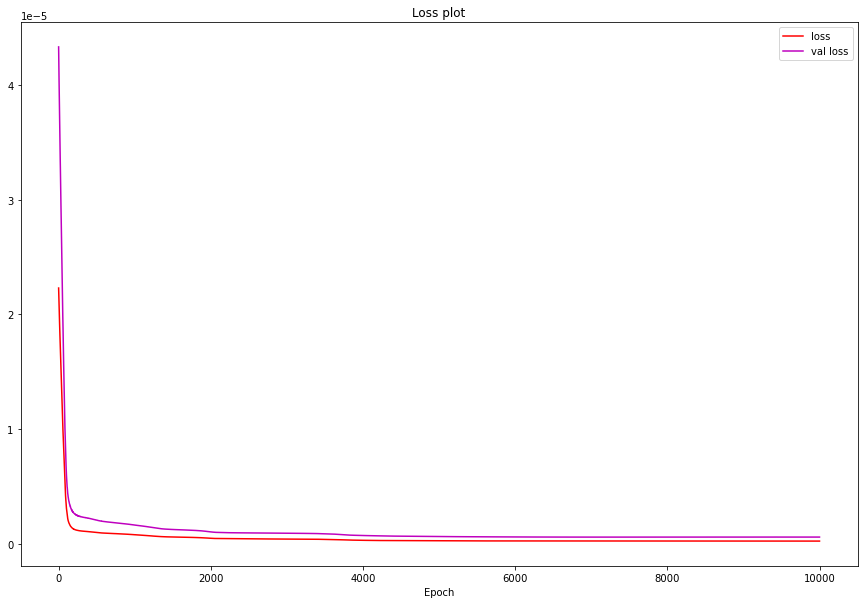

Training Loss before/after: 2.2289745948523626e-05, 2.3981357671068873e-07
Validation Loss before/after: 4.329839614273488e-05, 5.897074996697149e-07
Final loss: 2.3981357671068873e-07		Time taken: 82.21688151359558
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_FinalCreationtanh_lr0.001_n_epochs10000_n_mfcc12_n_hid10_n_timb6_5.897228460860621e-07.pt


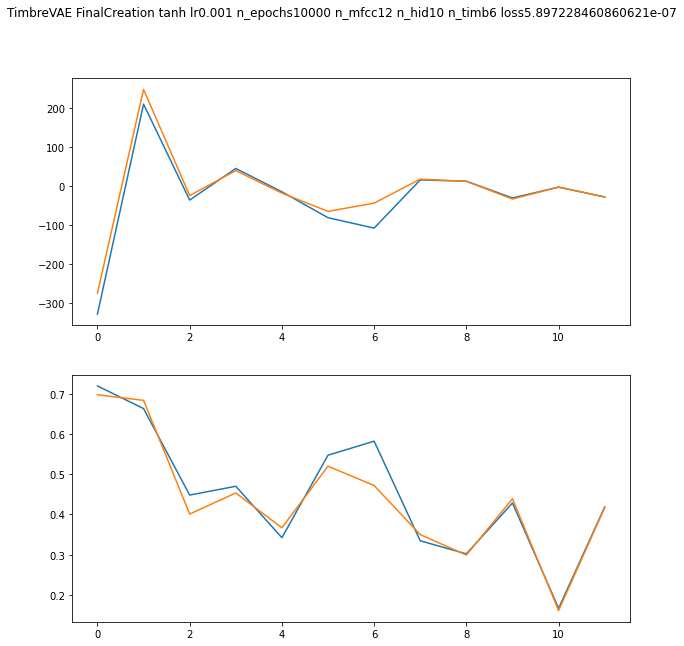

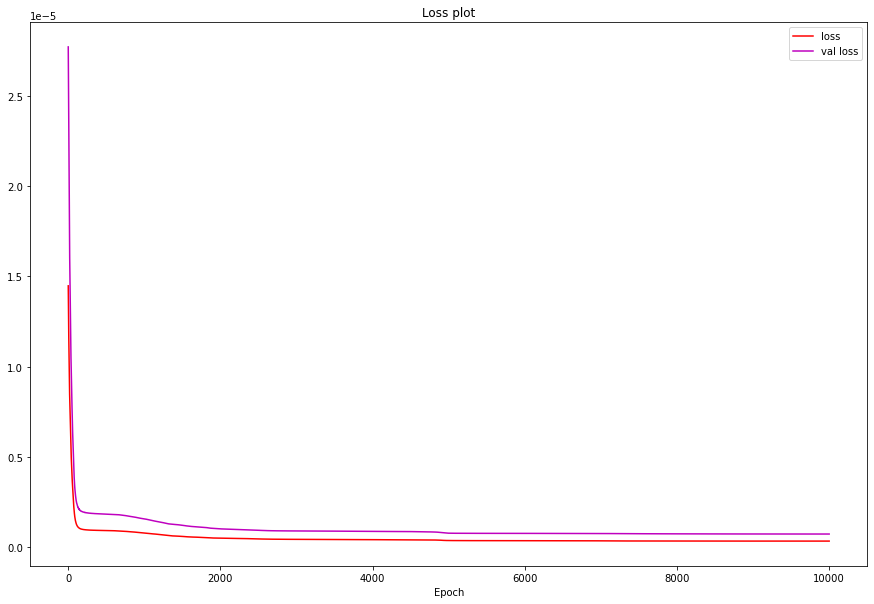

Training Loss before/after: 1.4465551116857035e-05, 3.3667076903598746e-07
Validation Loss before/after: 2.76900346166101e-05, 7.274374466164616e-07
Final loss: 3.3667076903598746e-07		Time taken: 74.98930859565735
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_FinalCreationtanh_lr0.001_n_epochs10000_n_mfcc24_n_hid22_n_timb10_7.274207202771186e-07.pt


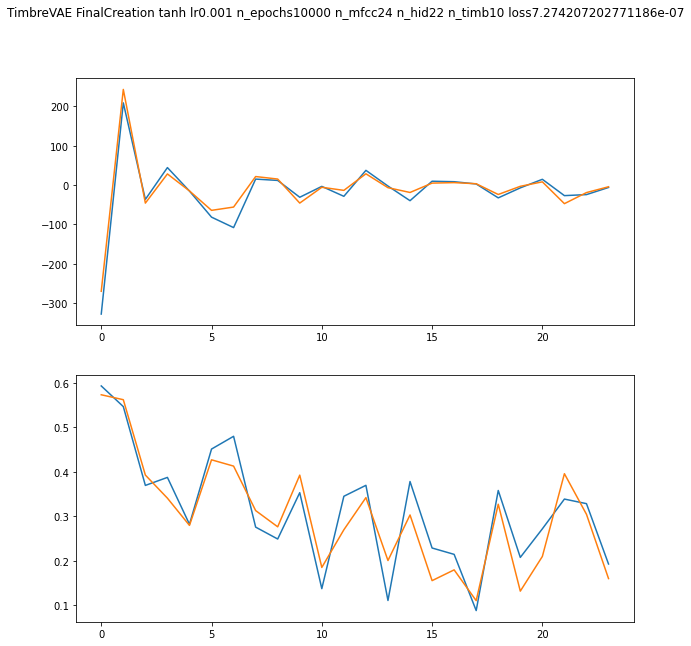

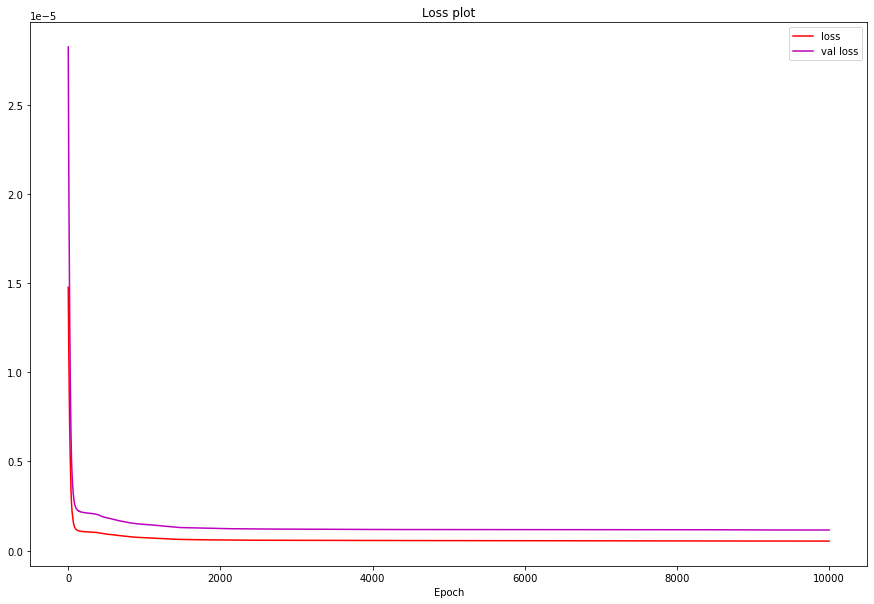

Training Loss before/after: 1.4760775020581553e-05, 5.325409697486495e-07
Validation Loss before/after: 2.824025089456432e-05, 1.1545675204552968e-06
Final loss: 5.325409697486495e-07		Time taken: 78.31953144073486
Model saved at model_data\TimbreVAE_Expts_nmels256_nfft2048\TimbreVAE_FinalCreationtanh_lr0.001_n_epochs10000_n_mfcc40_n_hid36_n_timb10_1.1545755490981813e-06.pt


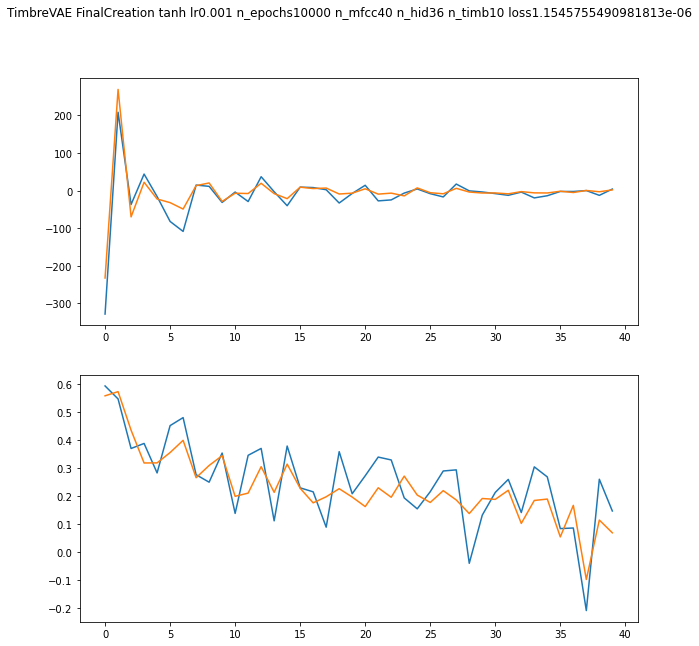

In [19]:
n_mels = 256
n_ffts = 2048

# # # # # # # # # # # # # # # # # # # # # # # # # #
# Data that is constant throughout the entire run #
# # # # # # # # # # # # # # # # # # # # # # # # # #

# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)
# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, win_length=n_ffts, plot=False) 
                              for waveform in all_wav_data ])

# Define loss 
loss_fn = nn.MSELoss()

# # # # # # # # # # # # # # # # # # # 
# Data that is constant per n_mfcc  #
# # # # # # # # # # # # # # # # # # # 

def create_data_for_mfcc(n_mfcc):
    # mels:         (576, 128, 58) (n_wavs, n_mels, n_windows)
    # mfccs:        (576, 20, 58)  (n_wavs, n_mfcc, n_windows)
    all_mels, all_mfcc = map(np.array, map(list, zip(*
                             [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                               for ffts in all_spectrograms ])))
    n_files, n_mfcc_dummy, n_windows = all_mfcc.shape

    # Returns a flat 2d idx, given a wavfile index and a window index
    flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
        wav_idx, win_idx, n_files, n_windows)

    # data:   (33408, 20) (n_wavs * n_windows, n_mfcc)
    data_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx] 
                              for wav_file_idx in range(n_files) 
                              for window_idx in range(n_windows) ])

    # Globally normalize to [-1, 1]
    # log(-n) is nan, so we put things on a log scale from absolute values, and
    # mutliply the sign back.
    signs = np.sign(data_prenorm)
    data_logged = np.log(np.abs(data_prenorm))
    max_mfcc = np.max(np.abs(data_logged))
    data = data_logged / max_mfcc
    
    # X_train: (22272, 20)
    # X_val: (11136, 20)
    X_train = []; X_val = [];
    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):
            # Choose the person for this pitch/vowel to be used as test data
            test_pid = int(np.random.rand() * 3)
            for pid_idx in range(n_people):
                wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                if (pid_idx != test_pid):
                    for win_idx in range(n_windows):
                        X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                else:
                    for win_idx in range(n_windows):
                        X_val.append(data[flat_data_idx(wav_idx, win_idx)])
    X_train, X_val = map(torch.tensor, (X_train, X_val))
    # Default tensor is float
    X_train = X_train.float(); X_val = X_val.float()
    
    return data, data_prenorm, max_mfcc, signs, flat_data_idx, X_train, X_val

# # # # # # # # # # # # # #
# Actual experiment loop  #
# # # # # # # # # # # # # # 

# Results: 
# Indices: [ [ n_mfcc, n_hid, n_timb ], [ ... ], ... ]
# Losses: [ loss1, loss2, ... ]
indices = []; train_losses = []; val_losses = [];

cands = [ [12, 10, 6],  [24, 22, 10], [40, 36, 10] ]

f = open(os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", "FinalCreation.txt"), "w")
for cand in cands:
    n_mfcc, n_hid, n_timb = cand
    data, data_prenorm, max_mfcc, signs, flat_data_idx, X_train, X_val = create_data_for_mfcc(n_mfcc)
    lr = 1e-3; n_epochs = 10000; batch_size=22272

    # Training model 
    model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

    # Use GPU if possible (will run on CPU otherwise)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Move inputs to GPU (if possible)
    X_train = X_train.to(device)
    X_val = X_val.to(device)

    # Move the network to GPU (if possible)
    model.to(device) 
    # Define optimizer 
    # opt = optim.SGD(model.parameters(), lr=lr)
    opt = optim.Adam(model.parameters(), lr=lr)

    # Fit the model
    tic = time.time()
    train_loss, val_loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                            epochs=n_epochs, print_graph = True, desc="n_mfcc{},n_hid{},n_timb{}".format(n_mfcc, n_hid, n_timb))
    toc = time.time()
    print('Final loss: {}\t\tTime taken: {}'.format(train_loss, toc - tic))
    model_path = os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
                              "TimbreVAE_FinalCreationtanh_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{}.pt"
                              .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
    torch.save(model.state_dict(), model_path)
    print("Model saved at {}".format(model_path))

    indices.append([n_mfcc, n_hid, n_timb]); train_losses.append(train_loss); val_losses.append(val_loss)

    # Create the validation printout and graph
    data_tensor = torch.tensor(data)
    data_tensor = data_tensor.float();
    data_tensor = data_tensor.to(device)

    wav_idx = flat_ref_idx(5, 5, 1)
    data_idx = flat_data_idx(wav_idx, 30)
    label = data_tensor[data_idx]
    pred, _, _ = model(data_tensor)

    # To restore:
    restored_pred = signs * np.e ** (pred.cpu().detach().numpy() * max_mfcc)

    # Visualize MFCCs
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle("TimbreVAE FinalCreation tanh lr{} n_epochs{} n_mfcc{} n_hid{} n_timb{} loss{}"
                 .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))
    # plt.figure()
    ax[0].plot(data_prenorm[data_idx])
    ax[0].plot(restored_pred[data_idx])
    # fig, ax = plt.subplots(2, 1)
    # plt.figure()
    ax[1].plot(data[data_idx])
    ax[1].plot(pred.cpu().detach().numpy()[data_idx])
    fig.savefig(os.path.join("model_data", "TimbreVAE_Expts_nmels256_nfft2048", 
        "TimbreVAE_FinalCreationtanh_lr{}_n_epochs{}_n_mfcc{}_n_hid{}_n_timb{}_{}.jpg"
                .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss)))

    # Numeric verification
    np.set_printoptions(suppress=True)
    f.write("TimbreVAE_FinalCreationtanh lr{} n_epochs{} n_mfcc{} n_hid{} n_timb{} loss{}"
            .format(lr, n_epochs, n_mfcc, n_hid, n_timb, val_loss))

    f.write(str(data_prenorm[data_idx]))
    f.write(str(restored_pred[data_idx]))
    f.write(str(data[data_idx]))
    f.write(str(pred.cpu().detach().numpy()[data_idx]))
f.close()



In [48]:
print(np.argmin(val_losses[1:8])+1)
for i in range(len(val_losses)):
    print(i, indices[i], val_losses[i])

1
0 [12, 10, 8] 2.2488103272264888e-07
1 [12, 10, 6] 1.1263185732023812e-06
2 [12, 10, 4] 1.7029106156665017e-06
3 [12, 8, 6] 1.1723956237707673e-06
4 [12, 8, 4] 2.330470490322887e-06
5 [12, 6, 4] 2.383953796688938e-06
6 [24, 22, 10] 1.407030537649561e-06
7 [40, 38, 10] 2.308088473857905e-06
